Финальный проект по временным рядам.

1. Мультивариативные ряды. Классификация или регрессия.
2. Один классический алгоритм.
3. Один НН алгоритм.

Мультивариативный ряд находится в папке data.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [69]:
df = pd.read_csv("data/dry_bean_dataset/Dry_Bean_Dataset.csv", sep = ";",decimal =",")
df.head

<bound method NDFrame.head of         Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0      28395    610.291       208.178117       173.888747      1.197191   
1      28734    638.018       200.524796       182.734419      1.097356   
2      29380    624.110       212.826130       175.931143      1.209713   
3      30008    645.884       210.557999       182.516516      1.153638   
4      30140    620.134       201.847882       190.279279      1.060798   
...      ...        ...              ...              ...           ...   
13606  42097    759.696       288.721612       185.944705      1.552728   
13607  42101    757.499       281.576392       190.713136      1.476439   
13608  42139    759.321       281.539928       191.187979      1.472582   
13609  42147    763.779       283.382636       190.275731      1.489326   
13610  42159    772.237       295.142741       182.204716      1.619841   

       Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  r

In [70]:
def data_overview(df, head=5):
    print(" MISSING VALUES ".center(125,'-'))
    print(df.isnull().sum())
    print(" DUPLICATED VALUES ".center(125,'-'))
    print(df.duplicated().sum())
    print(" DATA TYPES ".center(125,'-'))
    print(df.dtypes)

data_overview(df)

------------------------------------------------------- MISSING VALUES ------------------------------------------------------
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64
----------------------------------------------------- DUPLICATED VALUES -----------------------------------------------------
68
--------------------------------------------------------- DATA TYPES --------------------------------------------------------
Area                 int64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
AspectRation       float64
Eccentricity       float64
ConvexArea           int64
EquivDiameter      float64
Extent             float64
Solidi

In [86]:
df.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

In [71]:
m_dict = {
    "Class":{"SEKER":0, "BARBUNYA":1, "BOMBAY":2, "CALI":3, "HOROZ":4, "SIRA":5, "DERMASON":6} 
}

df = df.replace(m_dict)
df.head

<bound method NDFrame.head of         Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0      28395    610.291       208.178117       173.888747      1.197191   
1      28734    638.018       200.524796       182.734419      1.097356   
2      29380    624.110       212.826130       175.931143      1.209713   
3      30008    645.884       210.557999       182.516516      1.153638   
4      30140    620.134       201.847882       190.279279      1.060798   
...      ...        ...              ...              ...           ...   
13606  42097    759.696       288.721612       185.944705      1.552728   
13607  42101    757.499       281.576392       190.713136      1.476439   
13608  42139    759.321       281.539928       191.187979      1.472582   
13609  42147    763.779       283.382636       190.275731      1.489326   
13610  42159    772.237       295.142741       182.204716      1.619841   

       Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  r

In [72]:
df.shape

(13611, 17)

Пропущенных значений нет

In [73]:
# кол-во элементов для тестовой выборки
test_split_number=round(len(df)*0.25)
test_split_number

3403

In [74]:
# разбиваем датасет на тестовый и обучающий
train=df[:-test_split_number]
test=df[-test_split_number:]


print(train.shape)
print(test.shape)

(10208, 17)
(3403, 17)


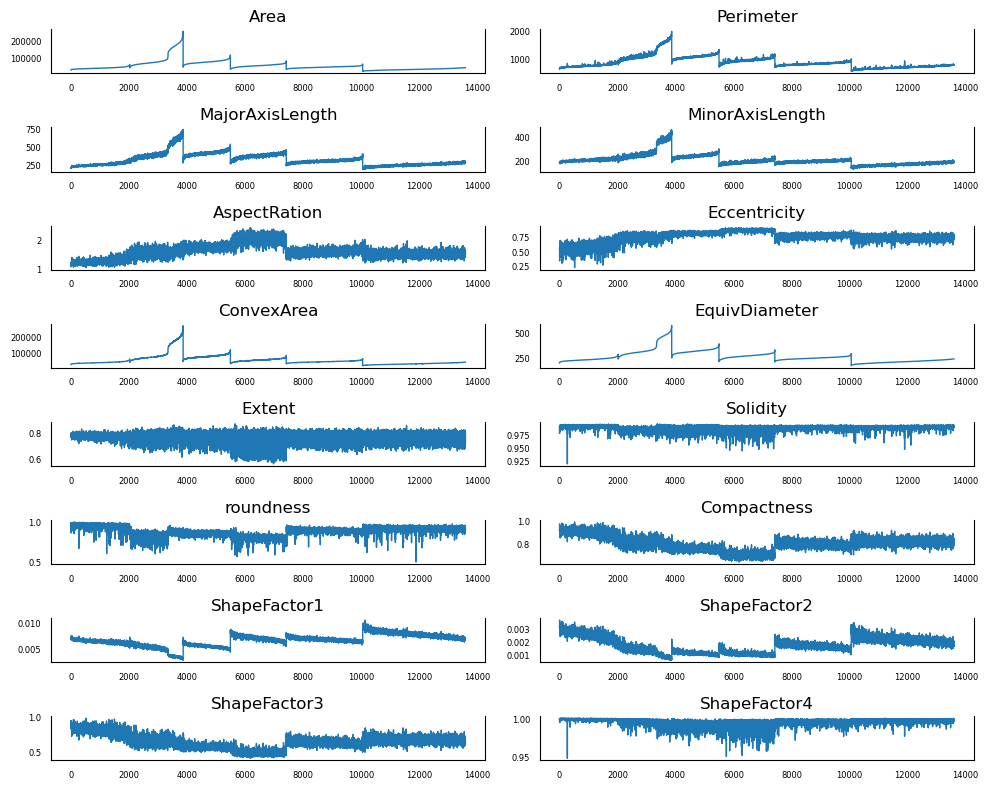

In [75]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [76]:
#Функция теста Адфулера на стационарность
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    # if p_value <= signif:
    #     print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    #     print(f" => Ряд стационарный.")
    # else:
    #     print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    #     print(f" => Ряд не стационарный.")  

    if output["pvalue"] < signif  :
        print(f"Значение p меньше {signif * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {signif*100}%. Ряд не стационарный.")

In [77]:
#Проверка на стационарность
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')
#Как можно видеть все ряды стационарные на уровне значимости 0.05

    Augmented Dickey-Fuller Test on "Area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4562
 No. Lags Chosen       = 4
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
Значение p меньше 5.0%. Ряд стационарный.


    Augmented Dickey-Fuller Test on "Perimeter" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.877
 No. Lags Chosen       = 9
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
Значение p меньше 5.0%. Ряд стационарный.


    Augmented Dickey-Fuller Test on "MajorAxisLength" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7865
 No. Lags Ch

In [78]:
# Нормируем данные
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

In [79]:
train_scaled

array([[0.03405267, 0.05857388, 0.04426214, ..., 0.75099637, 0.98061988,
        0.        ],
       [0.03550018, 0.07755673, 0.03047881, ..., 0.88498696, 0.97497943,
        0.        ],
       [0.03825855, 0.06803484, 0.05263303, ..., 0.7361995 , 0.98719586,
        0.        ],
       ...,
       [0.01683633, 0.03289599, 0.05176047, ..., 0.49188357, 0.96321342,
        1.        ],
       [0.01686621, 0.03116455, 0.04749427, ..., 0.51989895, 0.96551814,
        1.        ],
       [0.01688329, 0.03854833, 0.0563011 , ..., 0.46398387, 0.94031526,
        1.        ]])

In [80]:
train_scaled.shape

(10208, 17)

In [81]:
test_scaled=scaler.transform(test)
test_scaled.shape

(3403, 17)

In [87]:
# если нестационарный, то удаляем тренд (помните дифференцирование ?) и опять проверяеми
# 1st difference
df_differenced = train.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Area" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -48.1235
 No. Lags Chosen       = 4
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
Значение p меньше 5.0%. Ряд стационарный.


    Augmented Dickey-Fuller Test on "Perimeter" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -40.9274
 No. Lags Chosen       = 8
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
Значение p меньше 5.0%. Ряд стационарный.


    Augmented Dickey-Fuller Test on "MajorAxisLength" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.8871
 No. Lag

In [88]:
# Чтобы выбрать правильный порядок модели VAR, мы итеративно подбираем возрастающие порядки модели VAR и выбираем порядок, который дает модель с наименьшим AIC.

from statsmodels.tsa.vector_ar.var_model import VAR


model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

c:\Users\kanze\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  -102.70243923262073
BIC :  -102.48564482689304
FPE :  2.494005404572563e-45
HQIC:  -102.6291300606438 

Lag Order = 2
AIC :  -104.21191695211806
BIC :  -103.7903366797251
FPE :  5.5123872267357366e-46
HQIC:  -104.06935860957171 

Lag Order = 3
AIC :  -105.02744831427997
BIC :  -104.40104758808756
FPE :  2.438705738049378e-46
HQIC:  -104.81562843101271 

Lag Order = 4
AIC :  -105.55141990783474
BIC :  -104.72016413135518
FPE :  1.4441167301478154e-46
HQIC:  -105.27032611025388 

Lag Order = 5
AIC :  -105.99793079832632
BIC :  -104.96178536571489
FPE :  9.240309322427871e-47
HQIC:  -105.64755070939663 

Lag Order = 6
AIC :  -106.23705947962104
BIC :  -104.99598977567258
FPE :  7.275056347049521e-47
HQIC:  -105.8173807188635 

Lag Order = 7
AIC :  -106.45083848690713
BIC :  -105.00480988705266
FPE :  5.874843020664281e-47
HQIC:  -105.96184867039767 

Lag Order = 8
AIC :  -106.58267408722708
BIC :  -104.9316519575302
FPE :  5.149258664657358e-47
HQIC:  -106.02436082759

In [84]:
# другой вариает - автозаполнение. Лучшие метрики выделены *

x = model.select_order(maxlags=12)
x.summary()

In [89]:
# заполняем модель с лучшими параметрами
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Dec, 2023
Time:                     16:04:58
--------------------------------------------------------------------
No. of Equations:         17.0000    BIC:                   -104.465
Nobs:                     10195.0    HQIC:                  -106.100
Log likelihood:           302668.    FPE:                3.61650e-47
AIC:                     -106.936    Det(Omega_mle):     2.57813e-47
--------------------------------------------------------------------
Results for equation Area
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -1.995794        22.080127           -0.090           0.928
L1.Area                     2.655846         0.261781           10.145           0.000
L1.Perimeter               14.847103 

TypeError: VAR.fit() got an unexpected keyword argument 'epochs'

In [ ]:
# grid_search = grid_search.fit(x_train,y_train)

Epoch 1/8
Epoch 1/8
Epoch 1/8
Epoch 1/8
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/8
Epoch 1/8
Epoch 1/8
Epoch 1/8
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10


ValueError: 
All the 16 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_32" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_33" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_34" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_35" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_36" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_37" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_38" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_39" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_40" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_41" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_42" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_43" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_44" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_45" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_46" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kanze\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "c:\Users\kanze\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\kanze\AppData\Local\Temp\__autograph_generated_fileirard93s.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_47" is incompatible with the layer: expected shape=(None, 50, 13), found shape=(None, 50, 17)

